/var/folders/zc/fkpm0hsj0r1gzsj_01r5msv80000gn/T/ipykernel_62713/327750771.py:84: DtypeWarning: Columns (9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(self.input_filepath)


Processing NYC_4...
No data found for MW state 1 for NYC_4
Processing Mexico_1...
No data found for MW state 0 for Mexico_1
Processing Brazil_1...
No data found for MW state 1 for Brazil_1
Processing NYC_1...
No data found for MW state 0 for NYC_1
Processing Italy_1...
No data found for MW state 0 for Italy_1
Processing Sweden_4...
No data found for MW state 0 for Sweden_4
Processing India_3...
No data found for MW state 1 for India_3
Processing Mexico_3...
No data found for MW state 1 for Mexico_3
Processing HongKong_3...
No data found for MW state 0 for HongKong_3
Processing Italy_4...
No data found for MW state 1 for Italy_4
Processing London_1...
No data found for MW state 0 for London_1
Processing Russia_3...
No data found for MW state 1 for Russia_3
Processing India_1...
No data found for MW state 0 for India_1
Processing France_1...
No data found for MW state 0 for France_1
Processing Vietnam_2...
No data found for MW state 1 for Vietnam_2
Processing Vietnam_1...
No data found f

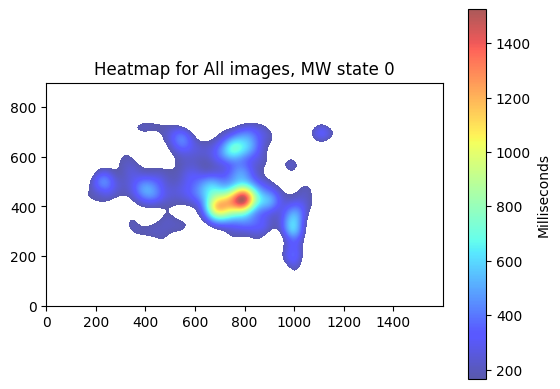

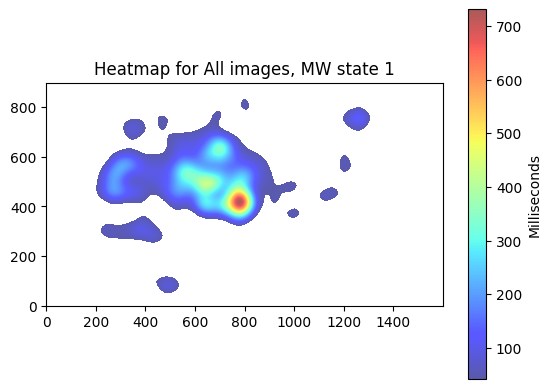

In [109]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2

class GazeHeatmap:
    def __init__(self, participant, window_size, display_width=1600, display_height=900, alpha=0.6, n_gaussian_matrix=100, standard_deviation=30, gaussian_threshold=0.8):
        self.root_dir = '../../../'
        self.participant = participant
        self.window_size = window_size # seconds
        self.window_frames = self.window_size * 60 # 60Hz
        self.display_width = display_width
        self.display_height = display_height
        self.alpha = alpha
        self.n_gaussian_matrix = n_gaussian_matrix
        self.standard_deviation = standard_deviation
        self.gaussian_threshold = gaussian_threshold
        
        self.input_filepath = os.path.join(self.root_dir, f'Preprocess/FreeViewing/Data/{self.participant}_IMG_1.csv')
        self.output_filedir = os.path.join(self.root_dir, 'Analysis/Visualization/FreeViewing/Result/Heatmap')
        if not os.path.exists(self.output_filedir):
            os.makedirs(self.output_filedir)

    def gaussian(self, x, sx, y=None, sy=None):
        if y is None:
            y = x
        if sy is None:
            sy = sx
        xo = x // 2
        yo = y // 2
        M = np.zeros([y, x], dtype=float)
        for i in range(x):
            for j in range(y):
                M[j, i] = np.exp(-1.0 * (((float(i) - xo) ** 2 / (2 * sx ** 2)) + ((float(j) - yo) ** 2 / (2 * sy ** 2))))
        return M

    def draw_heatmap(self, gaze_data, title):
        if not gaze_data:
            print(f"No valid gaze data for {title}. Skipping heatmap generation.")
            return

        gwh = self.n_gaussian_matrix
        gsdwh = gwh // 6 if (self.standard_deviation is None) else self.standard_deviation
        gaus = self.gaussian(gwh, gsdwh)
        strt = gwh // 2
        heatmapsize = self.display_height + 2 * strt, self.display_width + 2 * strt
        heatmap = np.zeros(heatmapsize, dtype=float)
        for x, y, _ in gaze_data:
            x = strt + x - gwh // 2
            y = strt + y - gwh // 2
            if 0 > x or x > self.display_width or 0 > y or y > self.display_height:
                continue
            heatmap[y:y + gwh, x:x + gwh] += gaus
        heatmap = heatmap[strt:self.display_height + strt, strt:self.display_width + strt]

        # Apply Gaussian blur to smooth the heatmap
        heatmap = cv2.GaussianBlur(heatmap, (21, 21), 0)

        if np.all(heatmap == 0):
            print(f"Heatmap for {title} has no data after Gaussian blur. Skipping visualization.")
            return

        lowbound = np.percentile(heatmap[heatmap > 0], int(self.gaussian_threshold * 100))  # Adjust the percentile as needed
        heatmap[heatmap < lowbound] = np.NaN
        
        plt.imshow(heatmap, cmap='jet', alpha=self.alpha, vmin=lowbound, vmax=np.nanmax(heatmap))
        plt.colorbar(label='Milliseconds')
        plt.title(f"Heatmap for {title}")
        plt.gca().invert_yaxis()
        plt.show()

    # Function to scale the coordinates from 1600x900 to 1920x1080
    def transform_coordinate(self, p):
        return (6 / 5 * p[0] - 1 / 10, 6 / 5 * p[1] - 1 / 10)

    def to_pixel(self, coord):
        coord = eval(coord)
        if len(coord) != 2 or coord[0] is None or coord[1] is None: return (None, None)
        coord = self.transform_coordinate(coord)
        return (coord[0] * self.display_width, coord[1] * self.display_height)

    def run(self):
        df = pd.read_csv(self.input_filepath)

        # Create 'MW' column based on 'state'
        df['MW'] = df['state'].apply(lambda x: 1 if x == 'num_6' else 0)
        
        mw_gaze_data = {0: [], 1: []}

        stimuli_names = df['stimuli'].dropna().unique()

        for image_name_clean in stimuli_names:
            print(f"Processing {image_name_clean}...")
            condition = df['stimuli'] == image_name_clean
            selected_data = df[condition].iloc[-self.window_frames:]

            if selected_data.empty:
                print(f"No data found for the given window size: {self.window_size} seconds for {image_name_clean}")
                continue

            for mw_state in [0, 1]:
                mw_condition = selected_data['MW'] == mw_state
                mw_data = selected_data[mw_condition]

                if mw_data.empty:
                    print(f"No data found for MW state {mw_state} for {image_name_clean}")
                    continue

                gaze_cor_name = "{}_gaze_point_on_display_area".format(df.loc[condition, 'eye_to_use'].iloc[0])
                mw_data['pixel_gaze_point'] = mw_data[gaze_cor_name].apply(self.to_pixel)
                gaze_data_list = mw_data['pixel_gaze_point'].tolist()
                filtered_gaze_data_list = [cor for cor in gaze_data_list if cor != (None, None)]
                mw_gaze_data[mw_state].extend([(int(cor[0]), int(cor[1]), 1) for cor in filtered_gaze_data_list])

        for mw_state in [0, 1]:
            self.draw_heatmap(mw_gaze_data[mw_state], f"All images, MW state {mw_state}")

if __name__ == '__main__':
    participant = '40K'
    window_size = 30 # seconds

    n_gaussian_matrix = 150
    standard_deviation = 30
    alpha = 0.65
    gaussian_threshold = 0.8

    heatmap = GazeHeatmap(participant, window_size, n_gaussian_matrix=n_gaussian_matrix, standard_deviation=standard_deviation, alpha=alpha, gaussian_threshold=gaussian_threshold)
    heatmap.run()
